In [2]:
!pip install ttach


[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import ttach as tta
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.optim
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.ops.focal_loss import sigmoid_focal_loss

import segmentation_models_pytorch as smp


from losses import AsymmetricLoss
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from load import *
#from load_data import *

from collections import OrderedDict

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Model Parameters
ARCHITECTURE = 'UnetPlusPlus'
ENCODER = 'resnet152' #timm-regnety_016
ENCODER_WEIGHT= 'imagenet' #imagenet
N_CLASSES = 1
ACTIVATION = None
DEPTH = 5
EPOCH = 200
OPTIMIZER = 'AdamW'
# SAVED_MODEL_PATH = '/root/jupyter/Dacon/deeplabv3p/model_save_1/'

# Train Parameters
BATCH_SIZE = 32
TRAIN_SET_RATIO = .9
VALID_SET_RATIO = .1

In [4]:
def get_transform_for_test():
    transform = A.Compose(
        [   
            A.MinMaxNormalize(),
            ToTensorV2()
        ]
    )
    return transform

def get_dataset(csv_path, transform):
    return SatelliteDataset(csv_file = csv_path, transform = transform)

def random_split_train_valid(dataset):
    data_size = len(dataset)
    train_size = int(data_size*TRAIN_SET_RATIO)
    valid_size = data_size - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    return train_dataset, valid_dataset

def get_data_loader(dataset, is_Train = True):
    return DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = is_Train)

def get_model(model_str: str):
    if model_str == 'Unet':
        return smp.Unet
    elif model_str == 'FPN':
        return smp.FPN
    elif model_str == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus
    elif model_str == 'UnetPlusPlus':
        return smp.UnetPlusPlus
    elif model_str == 'PAN':
        return smp.PAN
    elif model_str == 'MAnet':
        return smp.MAnet
    elif model_str == 'PSPNet':
        return smp.PSPNet

In [5]:
model = get_model(ARCHITECTURE)
model = model(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)

In [6]:
model = nn.DataParallel(model)

In [7]:
model.load_state_dict(torch.load('./model_save_unet_1/weight_epoch-0100.pth'))

<All keys matched successfully>

In [8]:
model.to(DEVICE)

DataParallel(
  (module): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu

In [9]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles = [0, 180]),
        tta.Resize(sizes = [(448,448)], original_size=(224,224), interpolation= "nearest")
        
    ]
)

In [10]:
tta_model = tta.SegmentationTTAWrapper(model, transforms,merge_mode= "mean")

In [11]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=get_transform_for_test(), infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

In [14]:
with torch.no_grad():
    tta_model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(DEVICE)
        
        # 1. model output
        outputs = tta_model(images)
        
        # 2. activation func and thresholding
        masks = torch.sigmoid(outputs).cpu().numpy()
        
        masks = (masks > .7).astype(np.uint8) 
       
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)
            
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

# change the file name.
# format : submit_{model_epoch}.csv
submit.to_csv(f'./submit/submit_{ARCHITECTURE}_{ENCODER}_{8279}.csv', index=False)

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/segmentation_models_pytorch/base/model.py", line 30, in forward
    decoder_output = self.decoder(*features)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/segmentation_models_pytorch/decoders/unetplusplus/decoder.py", line 129, in forward
    output = self.blocks[f"x_{depth_idx}_{depth_idx}"](features[depth_idx], features[depth_idx + 1])
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/segmentation_models_pytorch/decoders/unetplusplus/decoder.py", line 36, in forward
    x = F.interpolate(x, scale_factor=2, mode="nearest")
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py", line 3931, in interpolate
    return torch._C._nn.upsample_nearest2d(input, output_size, scale_factors)
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 23.69 GiB total capacity; 381.44 MiB already allocated; 41.12 MiB free; 476.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
idx = 0

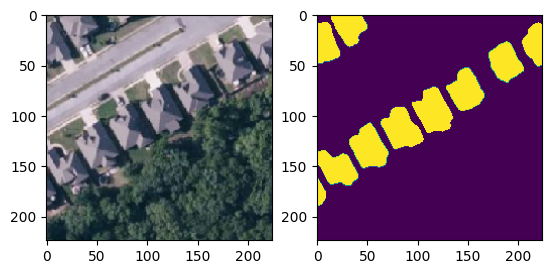

In [84]:
plt.subplot(1,2,1)
plt.imshow(images[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(masks[idx])
idx += 1

In [8]:
import os
import re
import glob

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import segmentation_models_pytorch as smp

#from loss import *
from load import *
from run_length_encoding import *
import ttach as tta
import matplotlib.pyplot as plt
from skimage import io, morphology


In [2]:
df = pd.read_csv('./submit/submit_DeepLabV3Plus_timm-efficientnet-b1_218_.csv')

In [107]:
idx = 60110

In [108]:
msk = rle_decode(str(df['mask_rle'][idx]), (224,224))

In [109]:
from skimage import io, morphology

open_msk = morphology.binary_opening(msk, morphology.square(3))

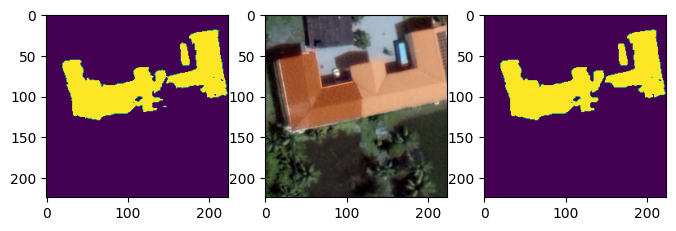

In [110]:
plt.figure(figsize = (8,10))
plt.subplot(1,3,1)
plt.imshow(msk)

plt.subplot(1,3,2)
plt.imshow(cv2.imread('./test_img/'+df['img_id'][idx]+'.png'))

plt.subplot(1,3,3)
plt.imshow(open_msk)

In [111]:
rle_encode(open_msk)

'4462 4 4678 14 4896 20 5113 27 5334 30 5555 33 5778 34 6001 35 6224 36 6448 35 6672 36 6898 34 7123 33 7347 33 7571 33 7796 33 8020 33 8230 6 8247 30 8453 8 8471 30 8677 8 8695 30 8901 8 8919 30 9125 9 9143 31 9349 9 9367 31 9573 9 9591 31 9798 8 9815 31 10022 8 10041 29 10246 9 10265 29 10470 9 10489 29 10694 9 10713 29 10918 9 10937 29 11142 9 11161 29 11366 9 11384 31 11590 10 11608 31 11814 10 11832 31 12038 10 12056 31 12262 10 12280 31 12486 11 12504 32 12574 13 12710 11 12729 31 12792 20 12934 11 12953 31 13015 21 13159 10 13177 31 13238 22 13383 10 13401 32 13461 22 13607 10 13625 32 13685 22 13832 9 13849 32 13909 23 14056 8 14073 32 14133 23 14297 32 14357 24 14522 31 14581 25 14674 13 14746 31 14805 25 14895 16 14969 32 15030 25 15118 17 15192 34 15254 25 15341 17 15413 37 15478 25 15564 19 15594 9 15635 39 15703 24 15788 19 15816 11 15855 43 15927 24 16012 20 16039 12 16075 47 16152 22 16236 21 16263 13 16293 53 16376 22 16460 21 16487 13 16513 58 16600 22 16685 20 16711 1